In [1]:
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import numpy as np

import wandb
import json

from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
api = wandb.Api()
artifact_path = 'yudai22-/condition_matching/training_log:v3'
artifact = api.artifact(artifact_path)

run = artifact.logged_by()


try:
    config_dict = json.loads(run.config)
    latent = config_dict["latent_num"]
    print(latent)
except json.JSONDecodeError:
    # run.config が有効なJSON文字列でなかった場合の処理
    print("エラー: run.config は有効なJSON形式ではありません。")
except TypeError:
    # run.config が文字列でなかった場合の処理 (念のため)
    print("エラー: run.config は文字列型ではありません。")


# latent = run.config["latent_num"]
# print(latent)

match = re.findall('/.*/', artifact_path)
log_name = re.search(r"(training.*)", artifact_path).group()

print(log_name)
print(match[0][1:-1])

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: Currently logged in as: yudai22 (yudai22-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'value': 100}
training_log:v3
condition_matching


In [11]:
all_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/all/{log_name}_all_latent.npy")
bubble_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/bubble/{log_name}_bubble_latent.npy")
view_all_region = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/normal/CygnusX_plone_mode_percentile_100x100.npy")
bubble_region = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/vflip/CygnusX_bubble_vflip.npy")

In [12]:
bubble_label = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/bubble_region_label.npy")

In [13]:
len(bubble_label[bubble_label==0])

5380

In [14]:
all_removed = []
for data, label in zip(all_region_latent, bubble_label):
    if label == 0:
        all_removed.append(data)
    else:
        pass

In [15]:
len(all_removed)

5380

In [16]:
all_plus_bubble_latent = np.concatenate((all_removed, bubble_region_latent))

In [17]:
tsne = TSNE(n_components=2, random_state=42)
digits_tsne = tsne.fit_transform(all_plus_bubble_latent)

In [18]:
cluster_labels = ["all"]*len(all_removed) + ["bubble"]*len(bubble_region_latent)

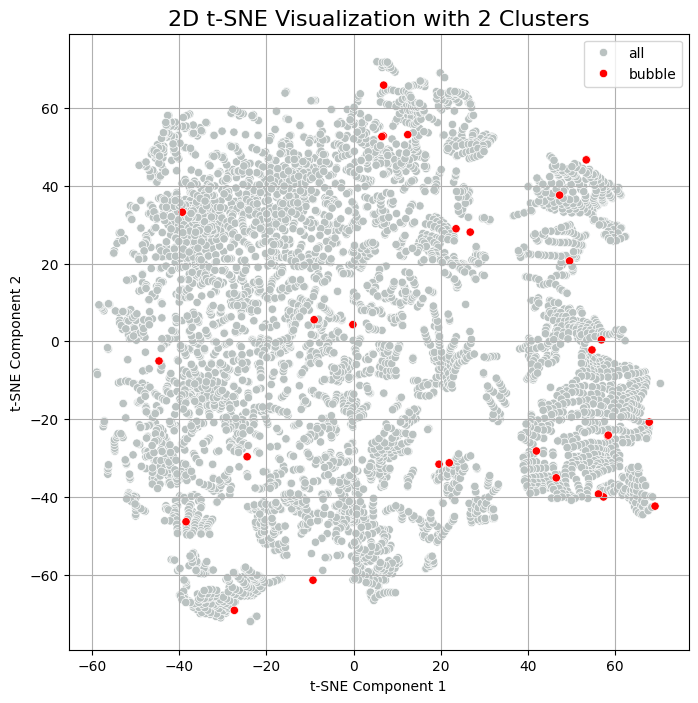

In [19]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=digits_tsne[:, 0], y=digits_tsne[:, 1], hue=cluster_labels, palette=["#bac2c1", "#ff0000"])
plt.title('2D t-SNE Visualization with 2 Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
# plt.savefig("2D_t-SNE_Visualization_Remove_Bubble")
plt.show()

In [20]:
tsne = TSNE(n_components=3, random_state=42)
digits_tsne_3d = tsne.fit_transform(all_plus_bubble_latent)

In [21]:
df_tsne_3d = pd.DataFrame({
    'tSNE_1': digits_tsne_3d[:, 0],
    'tSNE_2': digits_tsne_3d[:, 1],
    'tSNE_3': digits_tsne_3d[:, 2],
    'Cluster': cluster_labels # クラスタIDを文字列に変換
})

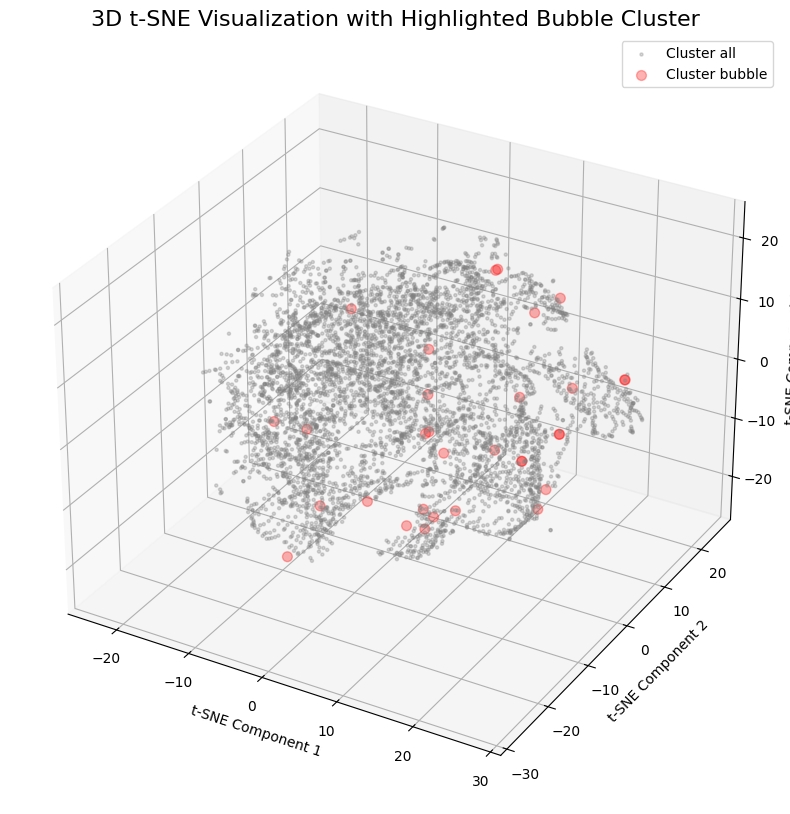

In [22]:
# %matplotlib widget

# グラフの準備
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d') # 👈 3Dプロット用の軸を作成

# クラスタごとに色を定義
cluster_colors = {
    'all': 'grey',
    'bubble': 'red'
}

# 各クラスタの点のサイズを定義
# デフォルトサイズ
default_point_size = 5
# bubbleクラスタのサイズ
bubble_point_size = 50 # 👈 bubbleクラスタの点を大きくするサイズ（例: 50）

# 各クラスタの点をプロット
for cluster_id, color in cluster_colors.items():
    subset = df_tsne_3d[df_tsne_3d['Cluster'] == cluster_id]
    
    # クラスタIDが 'bubble' の場合のみ点のサイズを変更
    current_point_size = bubble_point_size if cluster_id == 'bubble' else default_point_size
    
    ax.scatter(
        subset['tSNE_1'],
        subset['tSNE_2'],
        subset['tSNE_3'],
        color=color,
        label=f'Cluster {cluster_id}',
        alpha=0.3,
        s=current_point_size # 👈 ここで条件によってサイズが変わる
    )

# タイトルと軸ラベルの設定
ax.set_title('3D t-SNE Visualization with Highlighted Bubble Cluster', fontsize=16)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

# 凡例の表示
ax.legend()

plt.savefig("3D_t-SNE_Visualization_Remove_Bubble")
plt.show()